In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv("pimaDiabetes.csv")

# Separate features and labels
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# SMOTE (Synthetic Minority Oversampling Technique with k_neighbors=5 for diversity)
smote = SMOTE(random_state=42, k_neighbors=5)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X_train, y_train)

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Decision Tree parameters
dt_params = {
    'max_depth': [3, 5, 7, 10, 15], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Logistic Regression parameters
lr_params = {'C': [0.1, 1, 10], 'solver': ['liblinear']}

# Random Forest parameters
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Train Decision Tree on unbalanced dataset
dt_grid_unbalanced = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, scoring='recall', cv=5)
dt_grid_unbalanced.fit(X_train, y_train)
best_dt_unbalanced = dt_grid_unbalanced.best_estimator_

# Train Logistic Regression on unbalanced dataset
lr_grid_unbalanced = GridSearchCV(LogisticRegression(random_state=42), lr_params, scoring='recall', cv=5)
lr_grid_unbalanced.fit(X_train, y_train)
best_lr_unbalanced = lr_grid_unbalanced.best_estimator_

# Train Random Forest on unbalanced dataset
rf_grid_unbalanced = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, scoring='recall', cv=5)
rf_grid_unbalanced.fit(X_train, y_train)
best_rf_unbalanced = rf_grid_unbalanced.best_estimator_

# Train Decision Tree on Random Undersampling dataset
dt_grid_rus = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, scoring='recall', cv=5)
dt_grid_rus.fit(X_rus, y_rus)
best_dt_rus = dt_grid_rus.best_estimator_

# Train Logistic Regression on SMOTE dataset
lr_grid_smote = GridSearchCV(LogisticRegression(random_state=42), lr_params, scoring='recall', cv=5)
lr_grid_smote.fit(X_smote, y_smote)
best_lr_smote = lr_grid_smote.best_estimator_

# Train Random Forest on SMOTE + Tomek Links dataset
rf_grid_smote_tomek = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, scoring='recall', cv=5)
rf_grid_smote_tomek.fit(X_smote_tomek, y_smote_tomek)
best_rf_smote_tomek = rf_grid_smote_tomek.best_estimator_

In [12]:
from sklearn.metrics import classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Classification report for unbalanced dataset
y_pred_dt_unbalanced = best_dt_unbalanced.predict(X_test)
print("Decision Tree (Unbalanced):")
print(classification_report(y_test, y_pred_dt_unbalanced))

y_pred_lr_unbalanced = best_lr_unbalanced.predict(X_test)
print("Logistic Regression (Unbalanced):")
print(classification_report(y_test, y_pred_lr_unbalanced))

y_pred_rf_unbalanced = best_rf_unbalanced.predict(X_test)
print("Random Forest (Unbalanced):")
print(classification_report(y_test, y_pred_rf_unbalanced))

# Classification report for Random Undersampling dataset
y_pred_dt_rus = best_dt_rus.predict(X_test)
print("Decision Tree (Random Undersampling):")
print(classification_report(y_test, y_pred_dt_rus))

# Classification report for SMOTE dataset
y_pred_lr_smote = best_lr_smote.predict(X_test)
print("Logistic Regression (SMOTE):")
print(classification_report(y_test, y_pred_lr_smote))

# Classification report for SMOTE + Tomek Links dataset
y_pred_rf_smote_tomek = best_rf_smote_tomek.predict(X_test)
print("Random Forest (SMOTE + Tomek Links):")
print(classification_report(y_test, y_pred_rf_smote_tomek))

Decision Tree (Unbalanced):
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       150
           1       0.44      0.42      0.43        36

    accuracy                           0.78       186
   macro avg       0.65      0.65      0.65       186
weighted avg       0.78      0.78      0.78       186

Logistic Regression (Unbalanced):
              precision    recall  f1-score   support

           0       0.86      0.93      0.90       150
           1       0.58      0.39      0.47        36

    accuracy                           0.83       186
   macro avg       0.72      0.66      0.68       186
weighted avg       0.81      0.83      0.81       186

Random Forest (Unbalanced):
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       150
           1       0.71      0.33      0.45        36

    accuracy                           0.84       186
   macro avg       0.78      0.65     

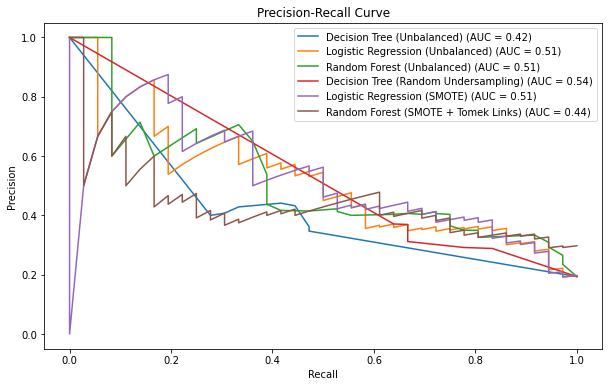

In [13]:
# Plot precision-recall curve and calculate AUC
def plot_precision_recall(y_test, y_pred_proba, label):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.2f})')

# Plot Precision-Recall curves for different models
plt.figure(figsize=(10, 6))

plot_precision_recall(y_test, best_dt_unbalanced.predict_proba(X_test)[:, 1], 'Decision Tree (Unbalanced)')
plot_precision_recall(y_test, best_lr_unbalanced.predict_proba(X_test)[:, 1], 'Logistic Regression (Unbalanced)')
plot_precision_recall(y_test, best_rf_unbalanced.predict_proba(X_test)[:, 1], 'Random Forest (Unbalanced)')
plot_precision_recall(y_test, best_dt_rus.predict_proba(X_test)[:, 1], 'Decision Tree (Random Undersampling)')
plot_precision_recall(y_test, best_lr_smote.predict_proba(X_test)[:, 1], 'Logistic Regression (SMOTE)')
plot_precision_recall(y_test, best_rf_smote_tomek.predict_proba(X_test)[:, 1], 'Random Forest (SMOTE + Tomek Links)')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()